In [1]:
import os 
from pathlib import Path 
from planttraits.config import TRAIN_IMAGES_FOLDER
from planttraits.utils import TARGET_COLUMN_NAMES, STD_COLUMN_NAMES
from planttraits.datasets.plant_traits_dataset import PlantTraitsDataset
from planttraits.models.example_model import PTNN
from torch.utils.data import DataLoader, random_split
from sklearn.preprocessing import StandardScaler, RobustScaler
import matplotlib.pyplot as plt
import pandas as pd 
from torchvision import transforms
import torchvision
import pytorch_lightning as pl
from torchmetrics.functional import r2_score, mean_squared_error
import torch
import torch.nn as nn
import warnings
import numpy as np

# Suppress all warnings
warnings.filterwarnings("ignore")

## Możliwe rozwiązania
1. Autoenkoder wielomodalny + FFN
2. Dwa oddzielne modele, potem fuzja do jednego
3. Feed Forward Network
4. XGBRegressor
5. Klasteryzacja

Możliwości dla 3 i 4:
- zastosowanie tylko wartości numerycznych
- przy pomocy gotowego modelu wygenerowanie embeddingów dla zdjęć, które są potem spłaszczane i dołączane do danych numerycznych

dla 2: [Dla tych co rozumieja Keras](https://www.kaggle.com/code/potcoveanuflorin/planttraits-efficientnet-image-tabular), lub z zeszłej edycji [rozwiązanie](https://www.kaggle.com/competitions/planttraits2023/discussion/425729), z obecnej edycji również proste [rozwiązanie](https://www.kaggle.com/code/nick33990/planttrait-convformer-mlp)

#### Co warto dodatkowo rozważyć
1. Klasyfikacja -> wybieramy wartości cech dla klasy przewidzianego gatunku, można też na podstawie znormalizowanych logitów obliczyć średnią ważoną i tak przewidzieć cechę

2. [X[*]_mean] jest wektorem przewidzianych cech - wykorzystanie odległości cosinusowej jako (dodatkowej) miary błędu

3. Walidacja k-krzyżowa, czyli wytrenowanie np. 5 takich samych modeli, ale każdy na innym podzbiorze danych, a końcowo uśrednić (średnia ważona?) przewidywania modeli. 

4. Porównać między sobą modele z różnymi bazowymi sieciami

5. Wykorzystać różne miary błędu, w tym R2, można też regularyzacje dodać (pewnie tu lepsze będzie L1)

### Przygotowanie danych

In [2]:
train_dataset = PlantTraitsDataset()

In [3]:
cols = train_dataset.data.columns
feat_cols = cols[~cols.isin([*TARGET_COLUMN_NAMES, *STD_COLUMN_NAMES])]
transf_cols = [*feat_cols, *STD_COLUMN_NAMES, TARGET_COLUMN_NAMES[0]]
len(cols), len(feat_cols), len(transf_cols)

(175, 163, 170)

Tu dla prostoty wszystkie wartości były tylko ustandaryzowane

In [4]:
scaler = StandardScaler()
target_scaler = RobustScaler()
targets = target_scaler.fit_transform(train_dataset.data[TARGET_COLUMN_NAMES[1:]].apply(np.log))
data = scaler.fit_transform(train_dataset.data[transf_cols])
data = pd.DataFrame(data, index=train_dataset.data.index, columns=[transf_cols])
data[TARGET_COLUMN_NAMES[1:]] = targets
data[STD_COLUMN_NAMES] = data[STD_COLUMN_NAMES].fillna(0)
train_dataset.data = data

Dla X4_mean nie można logarytmicznego przekształcenia zastosować bo zostają wartości nan

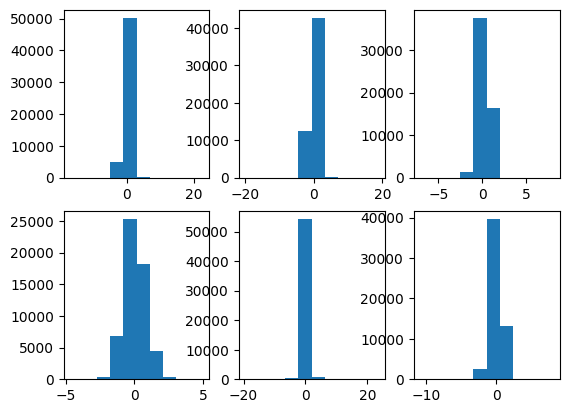

In [5]:
for i in range(len(TARGET_COLUMN_NAMES)):
    plt.subplot(2, 3, i + 1)
    plt.hist(train_dataset.data[TARGET_COLUMN_NAMES[i]])

(array([2.3700e+02, 8.5110e+03, 2.4927e+04, 1.5138e+04, 4.2210e+03,
        1.3170e+03, 7.2600e+02, 3.0500e+02, 8.9000e+01, 1.8000e+01]),
 array([-0.88921171, -0.58541046, -0.2816092 ,  0.02219205,  0.3259933 ,
         0.62979455,  0.9335958 ,  1.23739706,  1.54119831,  1.84499956,
         2.14880081]),
 <BarContainer object of 10 artists>)

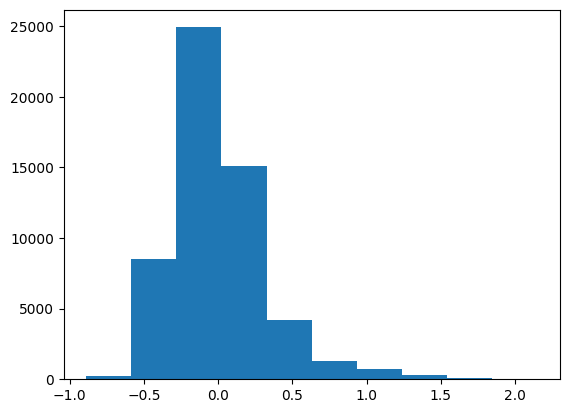

In [6]:
plt.hist(train_dataset.data.mean(axis=1))

In [7]:
train_dataset, val_dataset = random_split(train_dataset, [0.8, 0.2])

In [8]:
train_loader = DataLoader(train_dataset, batch_size=64)
val_loader = DataLoader(val_dataset, batch_size=64)

In [9]:
sample = next(iter(train_loader))

Dla modeli przetrenowanych najlepiej, by zakres wartości dla zdjęć był między 0 a 1. Można też w specyfikacji modelu podpatrzeć, np. [EfficientNet_B2](https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b2.html#torchvision.models.EfficientNet_B2_Weights), jakie transformacje były aplikowane do zdjęć, bo na pewno rozmiar wejściowy musi się zgadzać. 

In [10]:
train_transforms = transforms.Compose(
    [transforms.Resize(size=(232, 232)), 
     transforms.ConvertImageDtype(torch.float), 
     transforms.CenterCrop(size=224), 
     # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

In [11]:
train_transforms(sample[0])

tensor([[[[1.0773e-01, 1.0773e-01, 1.0773e-01,  ..., 2.5639e-01,
           2.5058e-01, 2.4447e-01],
          [1.1199e-01, 1.1199e-01, 1.1199e-01,  ..., 2.6324e-01,
           2.5749e-01, 2.5109e-01],
          [1.1385e-01, 1.1385e-01, 1.1383e-01,  ..., 2.6672e-01,
           2.6243e-01, 2.5615e-01],
          ...,
          [8.8852e-02, 8.8852e-02, 8.8852e-02,  ..., 8.2107e-02,
           7.9110e-02, 7.6381e-02],
          [8.4538e-02, 8.4538e-02, 8.4538e-02,  ..., 8.2145e-02,
           7.9118e-02, 7.6359e-02],
          [8.0280e-02, 8.0280e-02, 8.0280e-02,  ..., 8.2145e-02,
           7.9118e-02, 7.6359e-02]],

         [[9.9888e-02, 9.9888e-02, 9.9893e-02,  ..., 1.4788e-01,
           1.4576e-01, 1.4400e-01],
          [1.0415e-01, 1.0415e-01, 1.0418e-01,  ..., 1.5122e-01,
           1.4852e-01, 1.4517e-01],
          [1.0592e-01, 1.0592e-01, 1.0598e-01,  ..., 1.5308e-01,
           1.5214e-01, 1.4823e-01],
          ...,
          [6.1318e-02, 6.1318e-02, 6.1318e-02,  ..., 5.4573

In [12]:
efficientnet_b2 = torchvision.models.efficientnet_b2()

Zamrożenie wag!

In [13]:
for param in efficientnet_b2.parameters():
    param.requires_grad_(False)

In [14]:
for mod in efficientnet_b2.named_modules():
    print(mod)

('', EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAc

Funkcją ewaluującą (dla tego challenge) jest $R^2$, który obliczany jest wedle wzoru $$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$$ gdzie $SS_{res} = \sum{(\hat{y} - y) ^ 2}$ i $SS_{tot} = \sum{(\overline{y} - y) ^ 2}$ (proporcjonalne do estymacji wariancji) dla $\overline{y} = \frac{\sum{y}}{n}$. Jest normalnie w zakresie $(0, 1)$, gdzie *1* oznacza, że estymator jest dokładnie dopasowany (co może oznaczać jednak wysoką wariancję modelu) oraz $0$, gdy estymator zwraca jako predykcję $\overline{y}$ (wtedy model ma wysoki bias, nie jest wystarczająco skomplikowany). Możecie na podstawie krzywych uczenia i $R^{2}$ dopasowywać ilość i wielkość warstw w waszym modelu.

Jeśli to ma być funkcja straty, to trzeba ją 'odwrócić', czyli obliczać $1 - R^{2}$

In [15]:
kwargs = {
    "n_feat": len(feat_cols),
    "backbone_net": efficientnet_b2,
    "criteria": mean_squared_error
}

In [16]:
ptnn = PTNN(**kwargs)

In [17]:
pred, true = ptnn.run_forward(sample)

(array([[ 0.,  7., 13., 20., 18.,  6.,  0.,  0.,  0.,  0.],
        [ 9., 25., 17., 11.,  2.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  4., 15., 34., 11.],
        [ 0.,  0.,  0.,  1.,  1.,  8., 11., 23., 12.,  8.],
        [ 0.,  0.,  0.,  0.,  9., 24., 16., 12.,  2.,  1.],
        [ 8., 23., 17., 13.,  2.,  1.,  0.,  0.,  0.,  0.]]),
 array([-0.5241096 , -0.37430891, -0.22450824, -0.07470755,  0.07509313,
         0.22489381,  0.3746945 ,  0.52449518,  0.67429584,  0.82409656,
         0.97389722]),
 <a list of 6 BarContainer objects>)

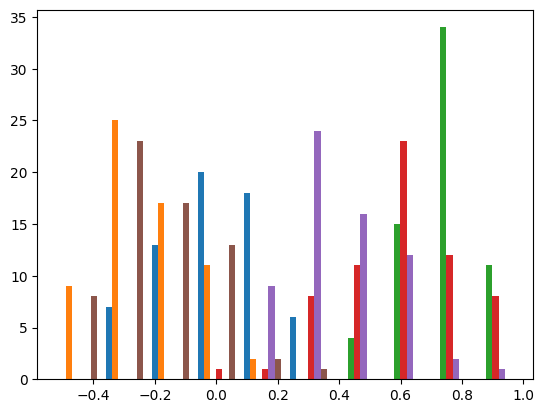

In [18]:
plt.hist(pred.detach().numpy())

(array([[ 0.,  0.,  7., 12., 12., 13., 10.,  6.,  4.,  0.],
        [ 2.,  8.,  4.,  7., 14., 20.,  4.,  1.,  4.,  0.],
        [ 0.,  0.,  0.,  8., 15., 16., 15.,  9.,  1.,  0.],
        [ 0.,  0.,  1.,  8., 22., 14., 11.,  5.,  3.,  0.],
        [ 0.,  0.,  4.,  8., 11., 16., 18.,  2.,  4.,  1.],
        [ 0.,  0.,  3., 11., 16., 16., 12.,  4.,  1.,  1.]]),
 array([-2.69991803, -2.1671977 , -1.6344775 , -1.10175729, -0.56903702,
        -0.03631675,  0.49640352,  1.02912378,  1.56184399,  2.0945642 ,
         2.62728453]),
 <a list of 6 BarContainer objects>)

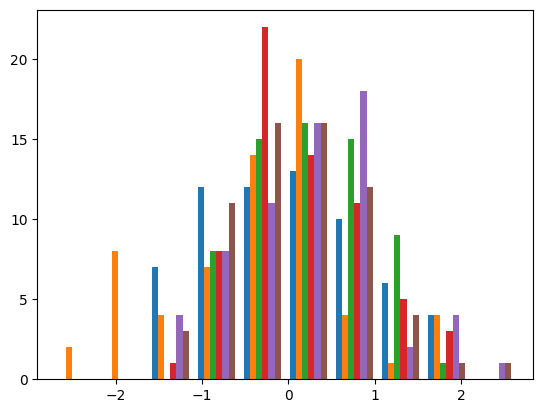

In [19]:
plt.hist(true.detach().numpy())

In [20]:
mean_squared_error(pred, true)

tensor(0.7948, grad_fn=<DivBackward0>)

In [21]:
true[:, 0]

tensor([ 0.2689,  0.6877,  0.4138, -0.0403, -0.6098,  1.6131, -0.4321,  1.0498,
        -1.3459, -0.1038, -0.8400, -0.8340,  0.2538,  0.3075, -0.0423, -0.9463,
         0.7322, -0.0203, -0.5967, -1.1489, -0.5736, -1.2703, -1.0111,  1.6357,
         1.1911, -0.2066, -0.0144, -0.4854, -0.0111,  0.3410, -0.4910,  1.0676,
         1.5450, -1.1629,  0.4996, -1.2038, -0.0898,  0.2906,  1.0829, -0.1169,
        -0.9645,  0.1765,  0.2114,  0.9502,  0.9660,  0.6043, -0.3097, -0.2816,
         0.0908, -0.1732,  0.6260, -0.6708,  1.8686, -0.6575, -1.0905,  0.2843,
        -0.6062,  0.5467,  0.7345, -1.3006, -1.4320,  1.6142,  1.3589,  0.9366])

In [22]:
checkpoint_dir = Path(f'../models')
os.makedirs(checkpoint_dir, exist_ok=True)
model_name = 'ptnn-effnetb2'
checkpoint_callback = pl.callbacks.ModelCheckpoint(dirpath=checkpoint_dir / model_name, filename='{epoch}-{val_loss:.2f}-{train_loss:.2f}', 
                                      monitor='val_loss', save_last=True) 
early_stopping = pl.callbacks.EarlyStopping(monitor='val_loss', verbose=True)
max_epochs = 20

"The R2 can result in large negative values. To prevent that we will only consider R2 values > 0." - jak sobie z tym poradzić?

Dodatkowo, jeśli tutaj w funkcji straty wyjdzie wam nan to prawdopodobnie jest jakaś wartość nan w danych

In [23]:
trainer = pl.Trainer(max_epochs=max_epochs, 
                     default_root_dir=checkpoint_dir / model_name, 
                     fast_dev_run=True, # True dla szybkiego przebiegu sprawdzającego, czy wszystkie warstwy są poprawne itd.
                     callbacks=[checkpoint_callback]
                     )

trainer.fit(ptnn, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
You are using a CUDA device ('NVIDIA GeForce RTX 4050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params | Mode 
-------------------------------------------------------
0 | climate_encoder | Sequential | 1.3 M  | train
1 | img_encoder     | Sequential | 9.8 M  | train
2 | prediction_head | Sequential | 1.2 M  | train
-------------------------------------------------------
3.2 M     Trainable params
9.1 M  

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1` reached.


In [24]:
pred, true = ptnn.run_forward(sample)

In [25]:
trainer = pl.Trainer(max_epochs=max_epochs, default_root_dir=checkpoint_dir / model_name, fast_dev_run=False)
model = PTNN.load_from_checkpoint(r'C:\Users\julia\VSCode\PlantTraits2024\models\ptnn-effnetb2\epoch=13-val_loss=0.67-train_loss=0.63.ckpt',
                                  **kwargs)
_ = model.eval()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [26]:
test_dataset = PlantTraitsDataset(preprocessors=train_dataset.dataset.return_preprocessors())
test_dataset.data[['X4_mean', *STD_COLUMN_NAMES]] = 0
data = scaler.transform(test_dataset.data[transf_cols])
test_dataset.data = pd.DataFrame(data, index=test_dataset.data.index, columns=[transf_cols])

In [27]:
test_dataset.data.index

Index([201238668, 202310319, 202604412, 201353439, 195351745, 195450369,
       196502338, 193570629, 202963682, 187448653,
       ...
       182307154, 202338101,  86683033, 164678035, 201559195, 195548469,
       199261251, 203031744, 197736382, 202625693],
      dtype='int64', name='id', length=6545)

In [28]:
test_loader = DataLoader(test_dataset, batch_size=64)

In [29]:
preds = trainer.predict(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [30]:
torch.concat(preds).shape

torch.Size([6545, 6])

In [31]:
test_dataset.data[TARGET_COLUMN_NAMES] = torch.concat(preds).numpy()

In [32]:
test_dataset.data

,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,SOIL_bdod_30.60cm_mean_0.01_deg,...,X18_sd,X26_sd,X50_sd,X3112_sd,X4_mean,X11_mean,X18_mean,X26_mean,X50_mean,X3112_mean
id,,,,,,,,,,,,,,,,,,,,,
201238668,-0.855775,1.544619,-0.079489,-1.145527,-0.522180,-0.840492,-2.095428,-2.073568,-2.382196,-2.505118,...,-0.018153,-0.013243,-0.470843,-0.10796,0.035845,-0.707527,-0.107979,-0.248685,0.410222,-0.621422
202310319,-0.492187,-0.731925,-0.807434,-1.198699,0.845956,0.444280,0.744238,0.977825,0.861629,0.698061,...,-0.018153,-0.013243,-0.470843,-0.10796,-0.416187,0.265335,-0.163865,-0.186900,-0.271442,-0.154387
202604412,-0.853296,-0.884779,-0.720161,-0.468310,0.642292,1.051957,0.914619,-0.415202,0.674485,-0.070702,...,-0.018153,-0.013243,-0.470843,-0.10796,-0.437976,-0.115116,-0.291509,-0.162424,0.210144,-0.483171
201353439,-0.988824,-0.233977,-0.496567,-0.621044,0.475902,-0.008435,-0.789182,-0.017194,-0.760284,-0.391020,...,-0.018153,-0.013243,-0.470843,-0.10796,-0.548490,0.479395,-0.363295,-0.400044,-0.420356,-0.180858
195351745,-1.290388,1.613367,0.088233,-1.028363,-0.176314,-0.296194,-1.811462,-1.741895,-1.883146,-1.736355,...,-0.018153,-0.013243,-0.470843,-0.10796,0.100044,-1.254910,-0.241866,-0.374351,0.399484,-0.864432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195548469,0.198399,0.221261,-0.361207,-0.997136,-0.468167,-0.722240,-0.618802,-0.282533,-0.635521,-0.391020,...,-0.018153,-0.013243,-0.470843,-0.10796,0.488991,-1.203344,0.189666,-0.103165,0.591164,-0.608002
199261251,1.222397,1.065181,1.081715,0.186324,-1.493906,-1.205005,-0.618802,-0.547871,-0.385996,-0.583211,...,-0.018153,-0.013243,-0.470843,-0.10796,0.183533,-0.047503,0.885772,0.867235,0.041807,0.908851
203031744,-0.222955,0.157715,-0.660990,-1.305533,1.104873,1.056471,0.744238,1.574837,1.547823,1.594951,...,-0.018153,-0.013243,-0.470843,-0.10796,-0.412976,0.444640,-0.004496,-0.130739,-0.492115,0.077394


Trzeba pamiętać, że na początku robiliśmy transformacje na zmiennych zależnych, więc z powrotem trzeba je przekształcić do prawidłowej postaci

In [33]:
denorm_pred = scaler.inverse_transform(test_dataset.data[transf_cols])[:, -1]

In [34]:
test_preds = np.c_[denorm_pred, target_scaler.inverse_transform(np.exp(test_dataset.data[TARGET_COLUMN_NAMES[1:]]))]

In [35]:
submission = pd.DataFrame(test_preds, index=test_dataset.data.index, columns=TARGET_COLUMN_NAMES).reset_index().rename({'index': 'id'}, axis=1)

In [36]:
submission.to_csv(TRAIN_IMAGES_FOLDER.parent / 'submission.csv', index=False)